<a href="https://colab.research.google.com/github/Dinesh-Adhithya-H/Machine-learning-in-Football/blob/main/Pass_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Xp model for passes during football matches

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import json
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression,Lasso,Ridge,SGDClassifier,LogisticRegression,SGDRegressor,LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.utils import shuffle
import xgboost
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data=pd.read_pickle("/content/drive/My Drive/passes_dataset (1).pkl")
data=shuffle(data)

In [ ]:
data

,pass_angle,pass_length,pass_outcome,duration,end_location_x,end_location_y,start_location_x,start_location_y
93,-1.390943,11.180340,Complete,0.899948,89.0,57.0,87.0,68.0
387,-0.730765,18.128983,Complete,1.555900,27.7,32.1,14.2,44.2
790,0.501013,57.462334,Complete,3.033300,90.6,33.4,40.2,5.8
482,-1.051650,16.124516,Complete,1.799000,79.0,40.0,71.0,54.0
909,-1.231504,18.027756,Complete,1.360000,18.0,22.0,12.0,39.0
...,...,...,...,...,...,...,...,...
6,1.808632,3.395585,Complete,0.503206,60.2,44.3,61.0,41.0
178,0.915242,43.143135,Complete,3.348105,52.4,74.2,26.1,40.0
818,-0.296115,6.168468,Complete,0.815277,71.5,14.2,65.6,16.0
128,0.165149,12.165525,Complete,0.107000,87.0,6.0,75.0,4.0


[]

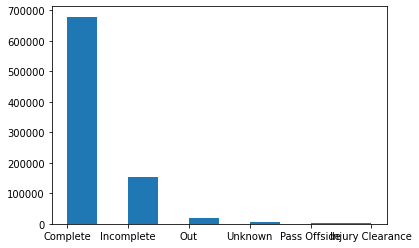

In [ ]:
plt.hist(data["pass_outcome"])
plt.plot()

In [ ]:
len(data[data["pass_outcome"]=="Incomplete"])+len(data[data["pass_outcome"]=="Out"]),len(data[data["pass_outcome"]=="Complete"])

(173101, 678693)

In [ ]:
data.to_pickle("passes_dataset.pkl")

In [ ]:
x=np.array(data[data["pass_outcome"]=="Incomplete"])[:,[0,1,3,4,5,6,7]]
x=np.append(x,np.array(data[data["pass_outcome"]=="Out"])[:,[0,1,3,4,5,6,7]],0)
p=np.array(data[data["pass_outcome"]=="Complete"].iloc[:173101])
X=np.append(x,p[:,[0,1,3,4,5,6,7]],0)
y=np.zeros(173101*2)
y[173101:]=1.0

In [ ]:
data.columns

Index(['pass_angle', 'pass_length', 'pass_outcome', 'duration',
       'end_location_x', 'end_location_y', 'start_location_x',
       'start_location_y'],
      dtype='object')

In [ ]:
X.shape,y.shape

((346202, 7), (346202,))

In [ ]:
xx=MinMaxScaler().fit(X)
x=xx.transform(X)

In [ ]:
x,y=shuffle(x,y,random_state=69)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y)

[07:24:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.2972342281425928


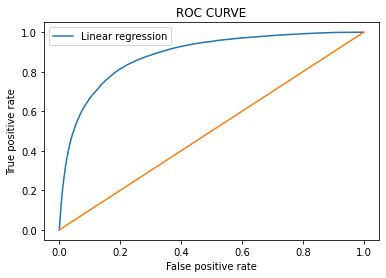

In [ ]:
lr=xgboost.XGBRegressor().fit(x_train,y_train)
print(np.mean(np.abs(lr.predict(x_test)-y_test)))
y_train_pred = lr.predict(x_test)
x,y,z=roc_curve(y_test,y_train_pred)
plt.plot(x,y,label="Linear regression")
plt.plot([0,1],[0,1])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [ ]:
roc_auc_score(y_test,y_train_pred)

0.8839165758093064

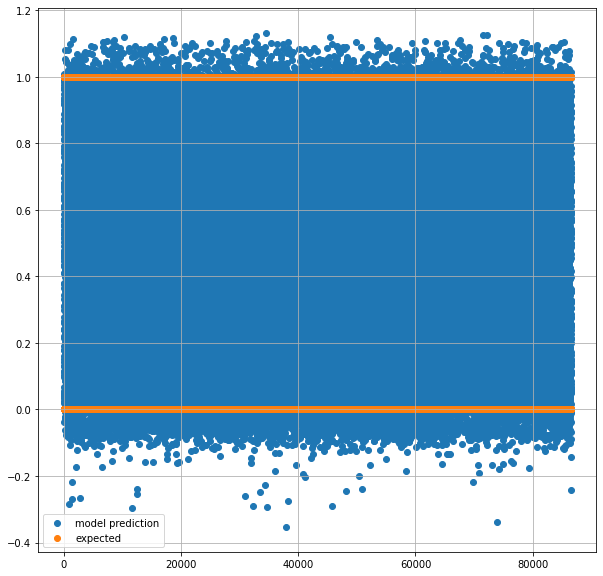

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(np.arange(len(y_train_pred)),y_train_pred,label="model prediction")
plt.scatter(np.arange(len(y_train_pred)),y_test,label="expected")
plt.legend()
plt.grid()
plt.show()

In [ ]:
confusion_marix=np.array([[0,0],[0,0]])
for i in range(len(y_test)):
  if y_train_pred[i]<=0.5:
    if y_train[i]==0.0:
      confusion_marix[0][0]+=1
    else:
      confusion_marix[0][1]+=1
  else:
    if y_train[i]==0.0:
      confusion_marix[1][0]+=1
    else:
      confusion_marix[1][1]+=1

In [ ]:
np.mean(np.abs(y_train_pred-y_test))

0.2972342281425928

In [ ]:
confusion_marix

array([[20953, 20878],
       [22269, 22451]])

In [ ]:
from sklearn.neural_network import MLPRegressor,MLPClassifier
regr = MLPClassifier(alpha=0.01,random_state=1, max_iter=500).fit(x_train, y_train)
regr.score(x_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.8067382237062541

In [ ]:
y_train_pred=regr.predict_proba(x_test)[:,1]
confusion_marix=np.array([[0,0],[0,0]])
for i in range(len(y_test)):
  if y_train_pred[i]<=0.5:
    if y_train[i]==0.0:
      confusion_marix[0][0]+=1
    else:
      confusion_marix[0][1]+=1
  else:
    if y_train[i]==0.0:
      confusion_marix[1][0]+=1
    else:
      confusion_marix[1][1]+=1

In [ ]:
confusion_marix

array([[20540, 20431],
       [22682, 22898]])

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:

model=tf.keras.models.Sequential([
  tf.keras.layers.Dense(1028,input_shape=x_train[0].shape),
  keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(1208,activation="relu"),
  keras.layers.Dropout(0.2),
  keras.layers.BatchNormalization(),
  #tf.keras.layers.Dense(1208,activation="relu"),
  #keras.layers.Dropout(0.3),
  #keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(2,activation="softmax")
])
model.compile(optimizer=keras.optimizers.Adam(lr=0.0005, decay=5e-7),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1028)              8224      
_________________________________________________________________
batch_normalization_5 (Batch (None, 1028)              4112      
_________________________________________________________________
dense_13 (Dense)             (None, 1208)              1243032   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1208)              0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 1208)              4832      
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 2418      
Total params: 1,262,618
Trainable params: 1,258,146
Non-trainable params: 4,472
________________________________________

In [ ]:
x_train=np.array(x_train)
y_train=np.array(y_train)
x_test=np.array(x_test)
y_test=np.array(y_test)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))

Epoch 1/10
8115/8115 [==============================] - 142s 17ms/step - loss: 0.5879 - accuracy: 0.7232 - val_loss: 0.4776 - val_accuracy: 0.7809
Epoch 2/10
8115/8115 [==============================] - 141s 17ms/step - loss: 0.4896 - accuracy: 0.7698 - val_loss: 0.4631 - val_accuracy: 0.7882
Epoch 3/10
8115/8115 [==============================] - 141s 17ms/step - loss: 0.4805 - accuracy: 0.7741 - val_loss: 0.4658 - val_accuracy: 0.7873
Epoch 4/10
8115/8115 [==============================] - 140s 17ms/step - loss: 0.4749 - accuracy: 0.7783 - val_loss: 0.4561 - val_accuracy: 0.7897
Epoch 5/10
8115/8115 [==============================] - 142s 18ms/step - loss: 0.4762 - accuracy: 0.7778 - val_loss: 0.4463 - val_accuracy: 0.7965
Epoch 6/10
8115/8115 [==============================] - 150s 18ms/step - loss: 0.4709 - accuracy: 0.7809 - val_loss: 0.4403 - val_accuracy: 0.8005
Epoch 7/10
8115/8115 [==============================] - 148s 18ms/step - loss: 0.4676 - accuracy: 0.7817 - val_loss: 0

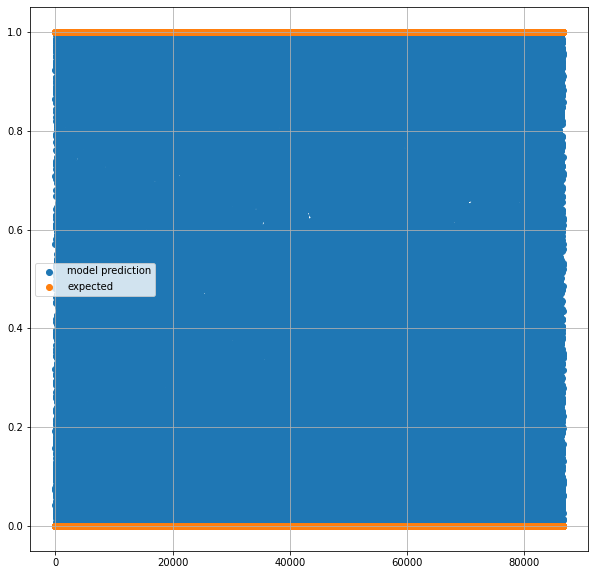

In [ ]:
y_train_pred = model.predict(x_test)
plt.figure(figsize=(10,10))
plt.scatter(np.arange(len(y_train_pred)),y_train_pred[:,1],label="model prediction")
plt.scatter(np.arange(len(y_train_pred)),y_test,label="expected")
plt.legend()
plt.grid()
plt.show()

In [ ]:
model.save('deep_learning_passes')

In [ ]:
!wget https://github.com/Dinesh-Adhithya-H/sports-analytics/blob/master/deep_learning_passes.h5?raw=true

--2021-03-05 09:21:13--  https://github.com/Dinesh-Adhithya-H/sports-analytics/blob/master/deep_learning_passes.h5?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Dinesh-Adhithya-H/sports-analytics/raw/master/deep_learning_passes.h5 [following]
--2021-03-05 09:21:14--  https://github.com/Dinesh-Adhithya-H/sports-analytics/raw/master/deep_learning_passes.h5
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Dinesh-Adhithya-H/sports-analytics/master/deep_learning_passes.h5 [following]
--2021-03-05 09:21:14--  https://raw.githubusercontent.com/Dinesh-Adhithya-H/sports-analytics/master/deep_learning_passes.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to r

In [ ]:
loaded_model = tf.keras.models.load_model("/content/deep_learning_passes.h5?raw=true")

In [ ]:
loaded_model.predict(x_test)

KeyboardInterrupt: ignored

In [ ]:
#model.predict(x_test[:10])

In [ ]:
np.mean(np.abs(y_train))

0.500148275955032

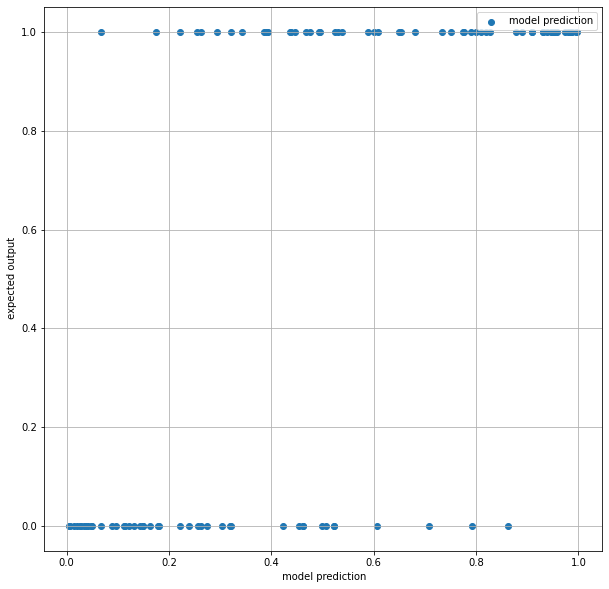

In [ ]:
plt.figure(figsize=(10,10))
x_test1=x_test[:100]
y_train_pred=loaded_model.predict(x_test1)[:,1]
plt.scatter(y_train_pred,y_test[:100],label="model prediction")
#plt.scatter(np.arange(len(y_train_pred)),y_test,label="expected")
plt.legend()
plt.ylabel(" expected output")
plt.xlabel(" model prediction")
plt.grid()
plt.show()

In [ ]:
!wget https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/69318.json

--2021-03-03 20:19:33--  https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/69318.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3433321 (3.3M) [text/plain]
Saving to: ‘69318.json’

69318.json          100%[===================>]   3.27M  --.-KB/s    in 0.1s    

2021-03-03 20:19:34 (24.5 MB/s) - ‘69318.json’ saved [3433321/3433321]



In [ ]:
match=pd.read_json("/content/69318.json")

In [ ]:
match.set_index(["id"],inplace=True)

In [ ]:
match.columns

Index(['index', 'period', 'timestamp', 'minute', 'second', 'type',
       'possession', 'possession_team', 'play_pattern', 'team', 'duration',
       'tactics', 'related_events', 'off_camera', 'player', 'position',
       'location', 'pass', 'carry', 'under_pressure', 'ball_receipt',
       'counterpress', 'interception', 'foul_won', 'foul_committed', 'duel',
       'out', 'shot', 'goalkeeper', 'clearance', 'dribble', 'ball_recovery',
       'substitution', 'block', 'bad_behaviour'],
      dtype='object')

In [ ]:
match

,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,team,duration,tactics,related_events,off_camera,player,position,location,pass,carry,under_pressure,ball_receipt,counterpress,interception,foul_won,foul_committed,duel,out,shot,goalkeeper,clearance,dribble,ball_recovery,substitution,block,bad_behaviour
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
88ff7166-cfba-4db1-8421-4ade1d9c03f3,1,1,2021-03-03 00:00:00.000,0,0,"{'id': 35, 'name': 'Starting XI'}",1,"{'id': 1049, 'name': 'Granada'}","{'id': 1, 'name': 'Regular Play'}","{'id': 1049, 'name': 'Granada'}",0.000000,"{'formation': 4411, 'lineup': [{'player': {'id...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0d0d253e-5e6d-45ee-9511-97674c4cb58d,2,1,2021-03-03 00:00:00.000,0,0,"{'id': 35, 'name': 'Starting XI'}",1,"{'id': 1049, 'name': 'Granada'}","{'id': 1, 'name': 'Regular Play'}","{'id': 217, 'name': 'Barcelona'}",0.000000,"{'formation': 433, 'lineup': [{'player': {'id'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02a5b418-297f-429d-9129-bf478e4fef76,3,1,2021-03-03 00:00:00.000,0,0,"{'id': 18, 'name': 'Half Start'}",1,"{'id': 1049, 'name': 'Granada'}","{'id': 1, 'name': 'Regular Play'}","{'id': 1049, 'name': 'Granada'}",0.000000,NaN,[db6fb452-9ef8-4a8c-865e-9ea9e3fd3a95],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
db6fb452-9ef8-4a8c-865e-9ea9e3fd3a95,4,1,2021-03-03 00:00:00.000,0,0,"{'id': 18, 'name': 'Half Start'}",1,"{'id': 1049, 'name': 'Granada'}","{'id': 1, 'name': 'Regular Play'}","{'id': 217, 'name': 'Barcelona'}",0.000000,NaN,[02a5b418-297f-429d-9129-bf478e4fef76],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e098f4a3-8338-4fca-9e80-26e8dd6d8920,5,1,2021-03-03 00:00:00.425,0,0,"{'id': 30, 'name': 'Pass'}",2,"{'id': 217, 'name': 'Barcelona'}","{'id': 9, 'name': 'From Kick Off'}","{'id': 217, 'name': 'Barcelona'}",0.800000,NaN,[8d58d445-3ee6-4f1f-afc4-0a613b98a8f7],1.0,"{'id': 5503, 'name': 'Lionel Andrés Messi Cucc...","{'id': 23, 'name': 'Center Forward'}","[61.0, 41.0]","{'recipient': {'id': 3958, 'name': 'Pedro Elie...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11a98ebb-0bfe-45ab-a2da-4be640c17c1e,4021,2,2021-03-03 00:48:32.807,93,32,"{'id': 43, 'name': 'Carry'}",161,"{'id': 217, 'name': 'Barcelona'}","{'id': 1, 'name': 'Regular Play'}","{'id': 217, 'name': 'Barcelona'}",1.798865,NaN,"[88d91f55-86f7-4b9d-b9c9-a587db2064ae, 93f85f7...",NaN,"{'id': 5506, 'name': 'Javier Alejandro Mascher...","{'id': 3, 'name': 'Right Center Back'}","[18.8, 56.5]",NaN,"{'end_location': [29.2, 61.6]}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93f85f7d-b026-47c5-8ea1-39e007ae6774,4022,2,2021-03-03 00:48:34.606,93,34,"{'id': 30, 'name': 'Pass'}",161,"{'id': 217, 'name': 'Barcelona'}","{'id': 1, 'name': 'Regular Play'}","{'id': 217, 'name': 'Barcelona'}",1.280584,NaN,[2894debd-3652-4a0f-9d24-79df321f8883],NaN,"{'id': 5506, 'name': 'Javier Alejandro Mascher...","{'id': 3, 'name': 'Right Center Back'}","[29.2, 61.6]","{'recipient': {'id': 4324, 'name': 'Daniel Alv...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2894debd-3652-4a0f-9d24-79df321f8883,4023,2,2021-03-03 00:48:35.886,93,35,"{'id': 42, 'name': 'Ball Receipt*'}",161,"{'id': 217, 'name': 'Barcelona'}","{'id': 1, 'name': 'Regular Play'}","{'id': 217, 'name': 'Barcelona'}",NaN,NaN,[93f85f7d-b026-47c5-8ea1-39e007ae6774],NaN,"{'id': 4324, 'name': 'Daniel Alves da Silva'}","{'id': 2, 'name': 'Right Back'}","[55.4, 74.5]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for i in range(1000):
  if str(match.iloc[i]["shot"])!="nan":
    print(match.iloc[i]["possession"])

17
20
21
23
33
35


In [ ]:
match

,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,team,duration,tactics,related_events,off_camera,player,position,location,pass,carry,under_pressure,ball_receipt,counterpress,interception,foul_won,foul_committed,duel,out,shot,goalkeeper,clearance,dribble,ball_recovery,substitution,block,bad_behaviour
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
88ff7166-cfba-4db1-8421-4ade1d9c03f3,1,1,2021-03-03 00:00:00.000,0,0,"{'id': 35, 'name': 'Starting XI'}",1,"{'id': 1049, 'name': 'Granada'}","{'id': 1, 'name': 'Regular Play'}","{'id': 1049, 'name': 'Granada'}",0.000000,"{'formation': 4411, 'lineup': [{'player': {'id...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0d0d253e-5e6d-45ee-9511-97674c4cb58d,2,1,2021-03-03 00:00:00.000,0,0,"{'id': 35, 'name': 'Starting XI'}",1,"{'id': 1049, 'name': 'Granada'}","{'id': 1, 'name': 'Regular Play'}","{'id': 217, 'name': 'Barcelona'}",0.000000,"{'formation': 433, 'lineup': [{'player': {'id'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02a5b418-297f-429d-9129-bf478e4fef76,3,1,2021-03-03 00:00:00.000,0,0,"{'id': 18, 'name': 'Half Start'}",1,"{'id': 1049, 'name': 'Granada'}","{'id': 1, 'name': 'Regular Play'}","{'id': 1049, 'name': 'Granada'}",0.000000,NaN,[db6fb452-9ef8-4a8c-865e-9ea9e3fd3a95],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
db6fb452-9ef8-4a8c-865e-9ea9e3fd3a95,4,1,2021-03-03 00:00:00.000,0,0,"{'id': 18, 'name': 'Half Start'}",1,"{'id': 1049, 'name': 'Granada'}","{'id': 1, 'name': 'Regular Play'}","{'id': 217, 'name': 'Barcelona'}",0.000000,NaN,[02a5b418-297f-429d-9129-bf478e4fef76],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e098f4a3-8338-4fca-9e80-26e8dd6d8920,5,1,2021-03-03 00:00:00.425,0,0,"{'id': 30, 'name': 'Pass'}",2,"{'id': 217, 'name': 'Barcelona'}","{'id': 9, 'name': 'From Kick Off'}","{'id': 217, 'name': 'Barcelona'}",0.800000,NaN,[8d58d445-3ee6-4f1f-afc4-0a613b98a8f7],1.0,"{'id': 5503, 'name': 'Lionel Andrés Messi Cucc...","{'id': 23, 'name': 'Center Forward'}","[61.0, 41.0]","{'recipient': {'id': 3958, 'name': 'Pedro Elie...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11a98ebb-0bfe-45ab-a2da-4be640c17c1e,4021,2,2021-03-03 00:48:32.807,93,32,"{'id': 43, 'name': 'Carry'}",161,"{'id': 217, 'name': 'Barcelona'}","{'id': 1, 'name': 'Regular Play'}","{'id': 217, 'name': 'Barcelona'}",1.798865,NaN,"[88d91f55-86f7-4b9d-b9c9-a587db2064ae, 93f85f7...",NaN,"{'id': 5506, 'name': 'Javier Alejandro Mascher...","{'id': 3, 'name': 'Right Center Back'}","[18.8, 56.5]",NaN,"{'end_location': [29.2, 61.6]}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93f85f7d-b026-47c5-8ea1-39e007ae6774,4022,2,2021-03-03 00:48:34.606,93,34,"{'id': 30, 'name': 'Pass'}",161,"{'id': 217, 'name': 'Barcelona'}","{'id': 1, 'name': 'Regular Play'}","{'id': 217, 'name': 'Barcelona'}",1.280584,NaN,[2894debd-3652-4a0f-9d24-79df321f8883],NaN,"{'id': 5506, 'name': 'Javier Alejandro Mascher...","{'id': 3, 'name': 'Right Center Back'}","[29.2, 61.6]","{'recipient': {'id': 4324, 'name': 'Daniel Alv...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2894debd-3652-4a0f-9d24-79df321f8883,4023,2,2021-03-03 00:48:35.886,93,35,"{'id': 42, 'name': 'Ball Receipt*'}",161,"{'id': 217, 'name': 'Barcelona'}","{'id': 1, 'name': 'Regular Play'}","{'id': 217, 'name': 'Barcelona'}",NaN,NaN,[93f85f7d-b026-47c5-8ea1-39e007ae6774],NaN,"{'id': 4324, 'name': 'Daniel Alves da Silva'}","{'id': 2, 'name': 'Right Back'}","[55.4, 74.5]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
match.iloc[0]["tactics"]

{'formation': 4411,
 'lineup': [{'jersey_number': 13,
   'player': {'id': 26659, 'name': 'Roberto Fernández Alvarellos'},
   'position': {'id': 1, 'name': 'Goalkeeper'}},
  {'jersey_number': 2,
   'player': {'id': 3991, 'name': 'Allan Romeo Nyom'},
   'position': {'id': 2, 'name': 'Right Back'}},
  {'jersey_number': 8,
   'player': {'id': 26573, 'name': 'Íñigo López Montaña'},
   'position': {'id': 3, 'name': 'Right Center Back'}},
  {'jersey_number': 5,
   'player': {'id': 26781, 'name': 'Diego Mainz García'},
   'position': {'id': 5, 'name': 'Left Center Back'}},
  {'jersey_number': 6,
   'player': {'id': 26780, 'name': 'Guilherme Magdalena Siqueira'},
   'position': {'id': 6, 'name': 'Left Back'}},
  {'jersey_number': 4,
   'player': {'id': 25707, 'name': 'Francisco Manuel Rico Castro'},
   'position': {'id': 9, 'name': 'Right Defensive Midfield'}},
  {'jersey_number': 14,
   'player': {'id': 6656, 'name': 'Mikel Rico Moreno'},
   'position': {'id': 11, 'name': 'Left Defensive Midfi

Index(['pass_angle', 'pass_length', 'pass_outcome', 'duration',
       'end_location_x', 'end_location_y', 'start_location_x',
       'start_location_y'],
      dtype='object')

In [ ]:
j=0
names_finished=[]
names_unfinished=[]
val1=[]
val=[]
for i in match["pass"]:
  if ((str(i)!="nan") and (match.iloc[j]["possession_team"]["name"]=="Barcelona")):
    v=[[i["angle"],i["length"],match.iloc[j]["duration"],i["end_location"][0],i["end_location"][1],match.iloc[j]["location"][0],match.iloc[j]["location"][1]]]
    #print([i["length"],i["end_location"][0],i["end_location"][1],match.iloc[j]["duration"],i["angle"]],i["recipient"]["name"])
    if "outcome" not in i:
      #print(model.predict(xx.transform(v)),i["outcome"]["name"],match.iloc[j]["player"]["name"])
      val.append(loaded_model.predict(xx.transform(v))[0][0])
      names_finished.append(match.iloc[j]["player"]["name"])
    else:
      val1.append(loaded_model.predict(xx.transform(v))[0][0])
      names_unfinished.append(match.iloc[j]["player"]["name"])
  j+=1

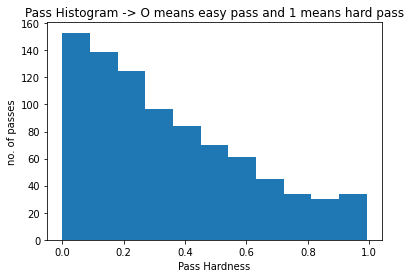

In [ ]:
h=plt.hist(val+val1,bins=11)
plt.xlabel("Pass Hardness")
plt.ylabel("no. of passes")
plt.title("Pass Histogram -> O means easy pass and 1 means hard pass")
plt.show()
# 0 means easy pass and 1 means hard pass.

Text(0.5, 1.0, 'FCB VS granada')

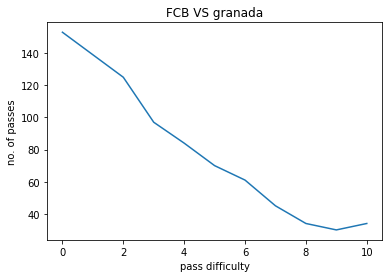

In [ ]:
plt.plot(h[0])
plt.xlabel("pass difficulty")
#plt.xlim(0,10)
plt.ylabel("no. of passes")
plt.title("FCB VS granada")

In [ ]:
dic1=dict()
count1=dict()
for i in set(names_finished):
  dic1[i]=0
  count1[i]=0
for j in range(len(val)):
  dic1[names_finished[j]]+=val[j]
  count1[names_finished[j]]+=1
#for i in dic.keys():
 # dic1[i]=dic1[i]/count[i]
#len(val1)
dic1

{'Andoni Iraola Sagarna': 0.31588980555534363,
 'Andrés Iniesta Luján': 15.87662428803742,
 'Carles Puyol i Saforcada': 8.893860260024667,
 'Carlos Gurpegi Nausia': 0.5012605134397745,
 'Eiður Smári Guðjohnsen': 0.056090518832206726,
 'Fernando Amorebieta Mardaras': 1.4237365890294313,
 'Fernando Llorente Torres': 0.14898407459259033,
 'Gerard Piqué Bernabéu': 14.467037248192355,
 'Gorka Iraizoz Moreno': 0.7205680012702942,
 'Javier Martínez Aginaga': 0.12421820312738419,
 'Koikili Lertxundi Del Campo': 0.16599173843860626,
 'Lionel Andrés Messi Cuccittini': 14.107860323041677,
 'Pablo Orbaiz Lesaka': 0.2881944477558136,
 'Rafael Márquez Álvarez': 26.06332459487021,
 'Samuel Eto"o Fils': 5.231393504887819,
 'Sergio Busquets i Burgos': 13.381220985203981,
 'Sylvio Mendes Campos Junior': 13.757654106942937,
 'Thierry Henry': 7.200826235115528,
 'Víctor Sánchez Mata': 1.139933854341507,
 'Víctor Valdés Arribas': 6.147984731942415,
 'Xavier Hernández Creus': 21.955527756363153}

In [ ]:
len(dic),len(dic1)

(21, 21)

In [ ]:
dic=dict()
count=dict()
for i in set(names_unfinished):
  dic[i]=0
  count[i]=0
for j in range(len(val1)):
  dic[names_unfinished[j]]+=val1[j]
  count[names_unfinished[j]]+=1
#for i in dic.keys():
  #dic[i]=dic[i]/count[i]
#len(val1)
dic

{'Andoni Iraola Sagarna': 2.280729651451111,
 'Andrés Iniesta Luján': 5.7065273225307465,
 'Carles Puyol i Saforcada': 7.835760712623596,
 'Carlos Gurpegi Nausia': 3.1426340341567993,
 'Eiður Smári Guðjohnsen': 0.831580400466919,
 'Fernando Amorebieta Mardaras': 0.9480466842651367,
 'Fernando Llorente Torres': 1.2741196751594543,
 'Francisco Javier Yeste Navarro': 0.8461228013038635,
 'Gaizka Toquero Pinedo': 0.7275760173797607,
 'Gerard Piqué Bernabéu': 3.509879946708679,
 'Gorka Iraizoz Moreno': 1.7095803022384644,
 'Igor Gabilondo del Campo': 0.8425222039222717,
 'Koikili Lertxundi Del Campo': 1.7275134921073914,
 'Lionel Andrés Messi Cuccittini': 7.395396530628204,
 'Markel Susaeta Laskurain': 0.6005381941795349,
 'Pablo Orbaiz Lesaka': 2.676512837409973,
 'Rafael Márquez Álvarez': 6.3921466916799545,
 'Samuel Eto"o Fils': 3.2964700162410736,
 'Sergio Busquets i Burgos': 2.868939980864525,
 'Sylvio Mendes Campos Junior': 3.4526977837085724,
 'Thierry Henry': 3.0297848880290985,
 'V

In [ ]:
df=pd.DataFrame()
df["names"]=dic.keys()
#df["pass difficulty of completed passes"]=dic1.values()
df["pass difficulty of incompleted passes"]=dic.values()
df[" No. Incompleted passes"]=count.values()
df["Avg. pass difficulty"]=df["pass difficulty of incompleted passes"]/df[" No. Incompleted passes"]


In [ ]:
df

,names,pass difficulty of incompleted passes,No. Incompleted passes,Avg. pass difficulty
0,Igor Gabilondo del Campo,0.842522,1,0.842522
1,Xavier Hernández Creus,10.077682,11,0.916153
2,Víctor Valdés Arribas,11.020890,12,0.918407
3,Thierry Henry,3.029785,5,0.605957
4,Rafael Márquez Álvarez,6.392147,9,0.710239
5,Andrés Iniesta Luján,5.706527,9,0.634059
6,Fernando Amorebieta Mardaras,0.948047,2,0.474023
7,Markel Susaeta Laskurain,0.600538,1,0.600538
8,Pablo Orbaiz Lesaka,2.676513,3,0.892171
9,Koikili Lertxundi Del Campo,1.727513,2,0.863757


In [ ]:
df=pd.DataFrame()
df["names"]=dic1.keys()
#df["pass difficulty of completed passes"]=dic1.values()
df["pass difficulty of completed passes"]=dic1.values()
df[" No. completed passes"]=count1.values()
df["Avg. pass difficulty"]=df["pass difficulty of completed passes"]/df[" No. completed passes"]
df

,names,pass difficulty of completed passes,No. completed passes,Avg. pass difficulty
0,Xavier Hernández Creus,21.955528,82,0.267750
1,Víctor Valdés Arribas,6.147985,21,0.292761
2,Thierry Henry,7.200826,18,0.400046
3,Rafael Márquez Álvarez,26.063325,76,0.342938
4,Andrés Iniesta Luján,15.876624,53,0.299559
5,Fernando Amorebieta Mardaras,1.423737,3,0.474579
6,Pablo Orbaiz Lesaka,0.288194,1,0.288194
7,Koikili Lertxundi Del Campo,0.165992,1,0.165992
8,"Samuel Eto""o Fils",5.231394,14,0.373671
9,Lionel Andrés Messi Cuccittini,14.107860,43,0.328090


In [ ]:
# we can see above and find the GOAT is making lots of difficult passing.

if using this model in future use the features in the order of 

['pass_angle', 'pass_length','duration', 'end_location_x', 'end_location_y', 'start_location_x', 'start_location_y']

In [ ]:
match[match["possession"]==21]["pass"].dropna()

id
2635aa1a-5bce-4878-b176-34bd08de236a    {'recipient': {'id': 20177, 'name': 'Eric-Sylv...
97bf3b68-be45-460c-a51f-18d5bbd4fcf5    {'recipient': {'id': 20131, 'name': 'Xavier He...
9e2181e7-f5c6-412b-bf96-dfa1a4c7df62    {'recipient': {'id': 3478, 'name': 'Francesc F...
daa83d98-984a-4b2e-9502-97ffa1d5de09    {'recipient': {'id': 5506, 'name': 'Javier Ale...
e7526552-507f-41a6-9c59-49e0ada94d7f    {'recipient': {'id': 3478, 'name': 'Francesc F...
5479e085-8d41-450d-8fd7-184a02ed909c    {'recipient': {'id': 20131, 'name': 'Xavier He...
e2447281-d5b1-4bf2-a3e0-35dac6ff1eb0    {'recipient': {'id': 26776, 'name': 'Juan Isaa...
4f8cd2a7-1f39-4225-836e-b5f2e1446d1d    {'recipient': {'id': 26613, 'name': 'Maxwell S...
659156b4-844f-400a-b814-1aae55902f4d    {'recipient': {'id': 20131, 'name': 'Xavier He...
eb67819c-6c3b-4c19-9ab4-bc1c4f48b758    {'recipient': {'id': 26776, 'name': 'Juan Isaa...
708373f8-080d-4a8a-b06c-ebcfe9fc9d9f    {'recipient': {'id': 20131, 'name': 'Xavier He...
e35dd73

In [ ]:
match[match["possession"]==21]

,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,team,duration,tactics,related_events,off_camera,player,position,location,pass,carry,under_pressure,ball_receipt,counterpress,interception,foul_won,foul_committed,duel,out,shot,goalkeeper,clearance,dribble,ball_recovery,substitution,block,bad_behaviour
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2635aa1a-5bce-4878-b176-34bd08de236a,479,1,2021-03-03 00:11:17.878,11,17,"{'id': 30, 'name': 'Pass'}",21,"{'id': 217, 'name': 'Barcelona'}","{'id': 7, 'name': 'From Goal Kick'}","{'id': 217, 'name': 'Barcelona'}",2.512521,NaN,[30b347c3-fe1a-4324-aca8-f2b63cc2353f],NaN,"{'id': 20176, 'name': 'Víctor Valdés Arribas'}","{'id': 1, 'name': 'Goalkeeper'}","[7.0, 37.0]","{'recipient': {'id': 20177, 'name': 'Eric-Sylv...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30b347c3-fe1a-4324-aca8-f2b63cc2353f,480,1,2021-03-03 00:11:20.390,11,20,"{'id': 42, 'name': 'Ball Receipt*'}",21,"{'id': 217, 'name': 'Barcelona'}","{'id': 7, 'name': 'From Goal Kick'}","{'id': 217, 'name': 'Barcelona'}",NaN,NaN,[2635aa1a-5bce-4878-b176-34bd08de236a],NaN,"{'id': 20177, 'name': 'Eric-Sylvain Bilal Abid...","{'id': 5, 'name': 'Left Center Back'}","[9.3, 12.9]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8151b0dd-96b6-431d-bab7-06373a8508be,481,1,2021-03-03 00:11:20.390,11,20,"{'id': 43, 'name': 'Carry'}",21,"{'id': 217, 'name': 'Barcelona'}","{'id': 7, 'name': 'From Goal Kick'}","{'id': 217, 'name': 'Barcelona'}",0.149179,NaN,"[30b347c3-fe1a-4324-aca8-f2b63cc2353f, 97bf3b6...",NaN,"{'id': 20177, 'name': 'Eric-Sylvain Bilal Abid...","{'id': 5, 'name': 'Left Center Back'}","[9.3, 12.9]",NaN,"{'end_location': [10.5, 12.8]}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97bf3b68-be45-460c-a51f-18d5bbd4fcf5,482,1,2021-03-03 00:11:20.539,11,20,"{'id': 30, 'name': 'Pass'}",21,"{'id': 217, 'name': 'Barcelona'}","{'id': 7, 'name': 'From Goal Kick'}","{'id': 217, 'name': 'Barcelona'}",1.405800,NaN,[229d95a7-af58-4d52-8da1-fdfc194df3b2],NaN,"{'id': 20177, 'name': 'Eric-Sylvain Bilal Abid...","{'id': 5, 'name': 'Left Center Back'}","[10.5, 12.8]","{'recipient': {'id': 20131, 'name': 'Xavier He...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229d95a7-af58-4d52-8da1-fdfc194df3b2,483,1,2021-03-03 00:11:21.945,11,21,"{'id': 42, 'name': 'Ball Receipt*'}",21,"{'id': 217, 'name': 'Barcelona'}","{'id': 7, 'name': 'From Goal Kick'}","{'id': 217, 'name': 'Barcelona'}",NaN,NaN,[97bf3b68-be45-460c-a51f-18d5bbd4fcf5],NaN,"{'id': 20131, 'name': 'Xavier Hernández Creus'}","{'id': 13, 'name': 'Right Center Midfield'}","[30.3, 23.6]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2dc460bb-25a3-4eee-9386-441f50fb55dd,546,1,2021-03-03 00:12:11.969,12,11,"{'id': 14, 'name': 'Dribble'}",21,"{'id': 217, 'name': 'Barcelona'}","{'id': 7, 'name': 'From Goal Kick'}","{'id': 217, 'name': 'Barcelona'}",0.000000,NaN,"[892ac994-6a25-4bc9-893e-d974f70089ca, b7ff61c...",NaN,"{'id': 5503, 'name': 'Lionel Andrés Messi Cucc...","{'id': 23, 'name': 'Center Forward'}","[104.5, 57.4]",NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'outcome': {'id': 8, 'name': 'Complete'}}",NaN,NaN,NaN,NaN
fcfe2fc2-2aa5-4ff1-be13-81b81ab444e8,547,1,2021-03-03 00:12:11.969,12,11,"{'id': 43, 'name': 'Carry'}",21,"{'id': 217, 'name': 'Barcelona'}","{'id': 7, 'name': 'From Goal Kick'}","{'id': 217, 'name': 'Barcelona'}",0.937836,NaN,"[182fa5f2-d5cf-4d73-90e6-4443efa75456, 2d007cf...",NaN,"{'id': 5503, 'name': 'Lionel Andrés Messi Cucc...","{'id': 23, 'name': 'Center Forward'}","[104.5, 57.4]",NaN,"{'end_location': [103.5, 52.3]}",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2d007cff-0d4f-4b01-99fe-e26a454d9e18,548,1,2021-03-03 00:12:12.569,12,12,"{'id': 17, 'name': 'Pressure'}",2

In [ ]:
j=478
names_finished=[]
names_unfinished=[]
val1=[]
val=[]
for i in match[match["possession"]==21]["pass"]:
  if ((str(i)!="nan") and (match.iloc[j]["possession_team"]["name"]=="Barcelona")):
    v=[[i["angle"],i["length"],match.iloc[j]["duration"],i["end_location"][0],i["end_location"][1],match.iloc[j]["location"][0],match.iloc[j]["location"][1]]]
    #print([i["length"],i["end_location"][0],i["end_location"][1],match.iloc[j]["duration"],i["angle"]],i["recipient"]["name"])
    if "outcome" not in i:
      #print(model.predict(xx.transform(v)),i["outcome"]["name"],match.iloc[j]["player"]["name"])
      val.append(loaded_model.predict(xx.transform(v))[0][0])
      names_finished.append(match.iloc[j]["player"]["name"])
    else:
      val1.append(loaded_model.predict(xx.transform(v))[0][0])
      names_unfinished.append(match.iloc[j]["player"]["name"])
  j+=1

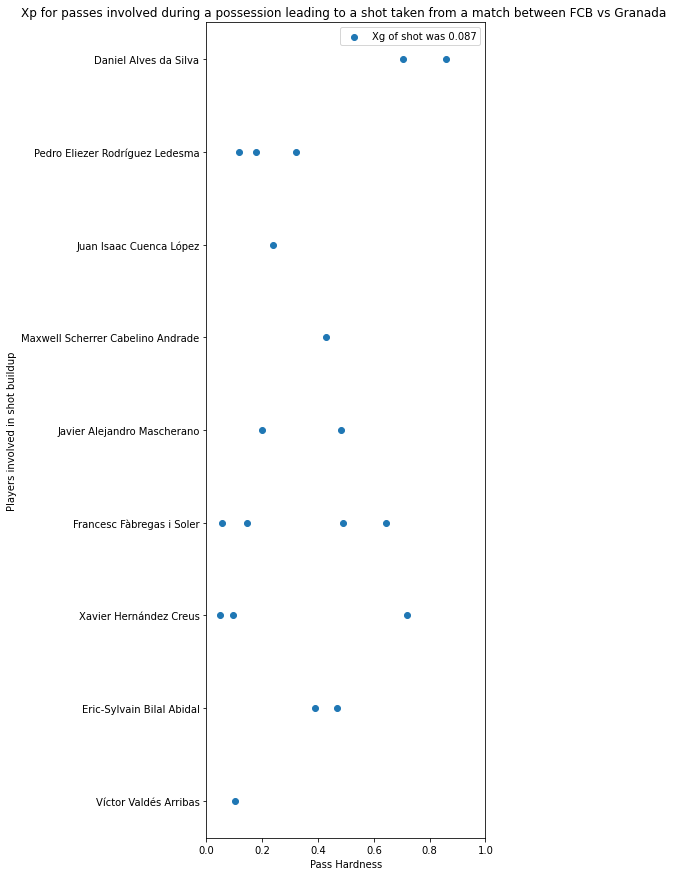

In [ ]:
plt.figure(figsize=(5,15))
plt.xlabel("Pass Hardness")
plt.xlim(0,1)
plt.ylabel("Players involved in shot buildup")
plt.scatter(val,names_finished,label="Xg of shot was 0.087")
plt.title("Xp for passes involved during a possession leading to a shot taken from a match between FCB vs Granada ")
plt.legend()
plt.show()

In [ ]:
val1,names_unfinished

([0.999995], ['Pedro Eliezer Rodríguez Ledesma'])

In [ ]:
match.iloc[548]["shot"]

{'body_part': {'id': 38, 'name': 'Left Foot'},
 'end_location': [120.0, 35.3, 0.9],
 'freeze_frame': [{'location': [100.4, 33.2],
   'player': {'id': 23995, 'name': 'Jaime Romero Gómez'},
   'position': {'id': 12, 'name': 'Right Midfield'},
   'teammate': False},
  {'location': [109.4, 36.7],
   'player': {'id': 3991, 'name': 'Allan Romeo Nyom'},
   'position': {'id': 2, 'name': 'Right Back'},
   'teammate': False},
  {'location': [110.3, 41.1],
   'player': {'id': 26573, 'name': 'Íñigo López Montaña'},
   'position': {'id': 3, 'name': 'Right Center Back'},
   'teammate': False},
  {'location': [108.3, 47.2],
   'player': {'id': 26781, 'name': 'Diego Mainz García'},
   'position': {'id': 5, 'name': 'Left Center Back'},
   'teammate': False},
  {'location': [107.7, 51.6],
   'player': {'id': 26780, 'name': 'Guilherme Magdalena Siqueira'},
   'position': {'id': 6, 'name': 'Left Back'},
   'teammate': False},
  {'location': [104.9, 52.5],
   'player': {'id': 6656, 'name': 'Mikel Rico More